In [1]:
import gensim

fname = "/Users/sullid/ONS/dp-search-service/src/main/resources/vectorModels/GoogleNews-vectors-negative300-SLIM.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(fname, binary=True)

In [69]:
# Collect the word vectors
import numpy as np

searchTerms = ["rpi", "gender pay gap", "cpi", "gdp", "inflation", "crime", "unemployment", 
              "population", "immigration", "mental health", "london", "london population", 
              "retail price index", "life expectancy", "obesity", "religion", "migration", 
              "poverty", "social media", "employment"]

word_vectors = []
words = []
for searchTerm in searchTerms:
    try:
        vec = model.word_vec(searchTerm)
        word_vectors.append(vec)
        words.append(searchTerm.lower())
        
        # Add similar words
        for word,score in model.similar_by_word(searchTerm):
            if (score > 0.5 and word.lower() not in words):
                vec = model.word_vec(word.lower())
                word_vectors.append(vec)
                words.append(word)
    except KeyError:
        pass
word_vectors = np.array(word_vectors)

# word_vectors = model.wv.syn0
n_words = word_vectors.shape[0]
vec_size = word_vectors.shape[1]

In [96]:
print n_words, vec_size
print words

from sklearn import decomposition

dimensions=2
pca = decomposition.PCA(n_components=dimensions)
pca_fit = pca.fit(word_vectors)

93 300
['cpi', 'gdp', u'dissaving', u'imf', 'inflation', u'inflationary', u'deflation', u'disinflation', u'deflationary', u'disinflationary', u'inflations', 'crime', u'crimes', u'murders', u'homicides', u'criminality', u'criminals', u'homicide', u'violence', 'unemployment', u'jobless', u'joblessness', u'unemployed', u'Underemployment', u'employment', u'underemployment', 'population', u'populations', u'populace', u'inhabitants', u'populaton', u'populous', u'landmass', 'immigration', u'immigrations', u'immigrants', u'deportations', u'deportation', u'immigrant', u'deporting', u'deport', 'london', u'birmingham', u'nyc', u'england', u'manchester', u'brooklyn', u'europe', u'essex', u'barcelona', u'alex', u'toronto', 'obesity', u'obese', u'diabetes', u'fatness', u'overeating', u'undernutrition', u'overweight', u'cholesterol', u'prematurity', 'religion', u'religions', u'religious', u'Christianity', u'Islam', u'faiths', u'spirituality', u'religiosity', u'morality', u'atheism', 'migration', u'mi

In [97]:
vectors = pca_fit.transform(word_vectors)
print vectors.shape

(93, 2)


Performing K-Means...
Done
Computing Euclidean distances...
Done
Computing pairwise distances...
Computing percentage of variance explained...
Plotting...
Optimal number of clusters =  3


/Users/sullid/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater


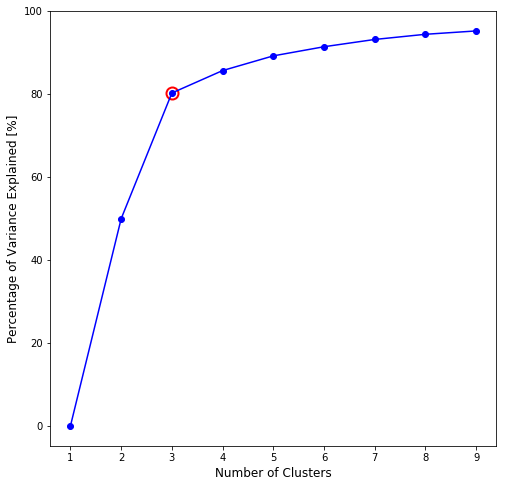

In [98]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fclusterdata

def eblow(data, n):
    print "Performing K-Means..."
    kMeansVar = [KMeans(n_clusters=k).fit(data) for k in range(1, n)]
    print "Done"
    centroids = [X.cluster_centers_ for X in kMeansVar]
    print "Computing Euclidean distances..."
    k_euclid = [cdist(data, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    print "Done"
    wcss = [sum(d**2) for d in dist]
    print "Computing pairwise distances..."
    pair_dist = pdist(data)
    print "Computing percentage of variance explained..."
    tss = sum(pair_dist**2)/data.shape[0]
    bss = tss - wcss
    percentage_variance = (bss/tss)*100.0
    
    K = range(1,n)
    seg_threshold = 0.95 #Set this to your desired target

    #The angle between three points
    def segments_gain(p1, v, p2):
        vp1 = np.linalg.norm(p1 - v)
        vp2 = np.linalg.norm(p2 - v)
        p1p2 = np.linalg.norm(p1 - p2)
        return np.arccos((vp1**2 + vp2**2 - p1p2**2) / (2 * vp1 * vp2)) / np.pi

    #Normalize the data
    criterion = np.array(avgWithinSS)
    criterion = (criterion - criterion.min()) / (criterion.max() - criterion.min())

    #Compute the angles
    seg_gains = np.array([0, ] + [segments_gain(*
            [np.array([K[j], criterion[j]]) for j in range(i-1, i+2)]
        ) for i in range(len(K) - 2)] + [np.nan, ])

    #Get the first index satisfying the threshold
    kIdx = np.argmax(seg_gains > seg_threshold)
    
    print "Plotting..."
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(K[kIdx], percentage_variance[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    
    ax.scatter(K, percentage_variance, color='b')
    ax.plot(K, percentage_variance, color='b')
    
    ax.set_xlabel("Number of Clusters", fontsize=12)
    ax.set_ylabel("Percentage of Variance Explained [%]", fontsize=12)
    
    print "Optimal number of clusters = ", K[kIdx]
    
    return kMeansVar
    
kMeansVar = eblow(vectors, 10)
plt.show()

In [103]:
import scipy.cluster.hierarchy as hcluster
import re
import nltk

def ncols(n, cmap='rainbow'):
    import matplotlib.pylab as plt
    cmap = plt.get_cmap(cmap)
    return cmap(np.linspace(0, 1, n))

class SemanticMap:
    def __init__(self, model, kOpt, vector_idx):
        self.model = model
        self.kOpt = kOpt
        self.vector_idx = vector_idx

    def __split_words(self, input_string):
        return re.findall(r"[\w']+", input_string)

    def __clean_words(self, words):
        clean_words = []
        for w in words:
            clean_words.append(re.sub(r'\W+', '', w.lower()))
        return clean_words

    def __remove_stop_words(self, words):
        return [w for w in words if not w in nltk.corpus.stopwords.words('english')]

    def __get_non_compositional_entity_vector(self, entity):
        return self.model[entity[0]]

    def __get_compositional_entity_vector(self, entity):
        array = np.array(self.model[entity[0]])
        for ind in range (1, len(entity)):
            array = array + np.array(self.model[entity[ind]])
        return array/len(entity)

    def __get_vector(self, term):
        words = self.__remove_stop_words(self.__clean_words(self.__split_words(term)))

        if len(words) < 1:
            print 'All the terms have been filtered.'
            raise
        if len(words) == 1:
            try:
                return self.__get_non_compositional_entity_vector(words)
            except:
                print 'Out-of-vocabulary entity'
                raise
        elif len(words) < 4:
            try:
                return self.__get_compositional_entity_vector(words)
            except:
                print 'Out-of-vocabulary word in compositional entity'
                raise
        else:
            print 'Entity is too long.'
            raise

    def __reduce_dimensionality(self, word_vectors, dimension=2):
        data = np.array(word_vectors)
        pca = decomposition.PCA(n_components=dimension)
        pca.fit(data)
        return pca.transform(data)

    def cluster_results(self, data, threshold=0.13):
        return hcluster.fclusterdata(data, threshold, criterion="distance")

    def map_words(self, words, sizes):
        final_words = []
        final_sizes = []
        vectors = []

        for word in words:
            try:
                vect = self.__get_vector(word)
                vectors.append(vect)
                if sizes is not None:
                    final_sizes.append(sizes[words.index(word)])
                final_words.append(word)
            except Exception as e:
                print 'not valid ' + word, e

        return vectors, final_words, final_sizes

    def plot(self, vectors, lemmas, clusters, figsize, sizes=80):
        fig,ax = plt.subplots(figsize=(12,12))
        if sizes == []:
            sizes = 80
        ax.scatter(vectors[:, 0], vectors[:, 1], s=sizes, c=clusters)
        
        cols = ncols(self.kOpt)
        for kn in range(self.kOpt):
            for label, x, y in zip(lemmas, vectors[:, 0], vectors[:, 1]):
                ix = lemmas.index(label)
                if (self.vector_idx[ix] == kn):
                    ax.annotate(
                        label,
                        xy = (x, y), xytext = (-20, 20),
                        textcoords = 'offset points', ha = 'right', va = 'bottom',
                        bbox = dict(boxstyle = 'round,pad=0.5', fc = cols[kn], alpha = 0.25),
                        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

        plt.show()

    def map_cluster_plot(self, words, sizes, threshold, figsize=(8,8)):
        vectors, words, sizes = self.map_words(words, sizes)
        vectors = self.__reduce_dimensionality(vectors)
        clusters = self.cluster_results(vectors, threshold)
        self.plot(vectors, words, clusters, sizes, figsize)

    def print_results(self, words, clusters):
        print words
        print clusters.tolist()

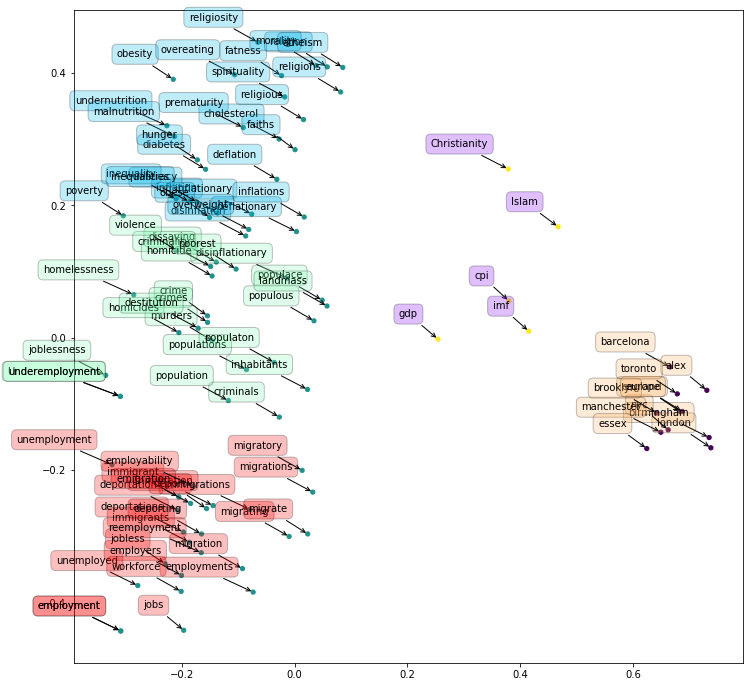

In [104]:
kOpt=5
vector_idx = kMeansVar[kOpt-1].fit_predict(vectors)
semantic_map = SemanticMap(model, kOpt, vector_idx)
semantic_map.map_cluster_plot(words, None, 0.2, figsize=(18,18))